# Generative Models

## GANs & VAE

### HW4

**Full Name:** Mehdi Jamalkhah

**SID:**

### Local Setup

In [1]:
import gdown
VAR_ROOT = "vars/gan-vae"
gdown.download_folder("https://drive.google.com/drive/folders/1xBjVN_9ff8XRVMUvY_NzMGz_h65A0acz?usp=sharing", output=VAR_ROOT, quiet=True)

['vars/gan-vae/resnet_history.pt',
 'vars/gan-vae/resnet.pt',
 'vars/gan-vae/unet_history.pt',
 'vars/gan-vae/unet.pt']

### Google Colab Setup

In [22]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL/HW4'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir('./'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: 'drive/My Drive/DL/HW4'

### Save/Load

In [4]:
import torch

def load(filename):
    return torch.load(VAR_ROOT + '/' + filename + '.pt', map_location=torch.device('cpu'))

def save(object, filename):
    filename = VAR_ROOT + '/' + filename + '.pt'
    if isinstance(object, torch.nn.Module):
        torch.save(object.state_dict(), filename)
    else:
        torch.save(object, filename)

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [6]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

CUDA = 'cuda'
DEVICE = CUDA if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [7]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [8]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

In [9]:
num_threads = 2
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

In [10]:
def show_image(img, label=None):
    plt.imshow(img[0], cmap='gray')
    plt.yticks([])
    plt.xticks([])
    if label != None:
        plt.title(f"Label: {label}")

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.relu2 = nn.ReLU()

        self.mean = nn.Linear(latent_dim, latent_dim)
        self.log_var = nn.Linear(latent_dim, latent_dim)


    def forward(self, x):
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)

        z_mean = self.mean(x)
        z_log_var = self.log_var(x)

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu2 = nn.ReLU()


    def forward(self, z):
        # Decode the latent vector `z` to images.
        x = self.fc1(z)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        return x

In [12]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def rand(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the reparameterization trick to ensure gradient flow.
        image_shape = x.shape
        z_mean, z_log_var = self.encoder(x.view(x.shape[0], -1))
        z = self.rand(z_mean, z_log_var)
        image = self.decoder(z).view(image_shape)
        return image, z_mean, z_log_var

In [13]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [14]:
def loss_function(x, recon_x, mu, logvar):
    recon_loss = nn.MSELoss(reduction="sum")(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

In [19]:
def train_vae(dataloader, model, learning_rate=1e-4, num_epochs=100):
    # Define the loss fc, optimizer and VAE model.
    criterion = loss_function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    sample_images, labels = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (data, _) in enumerate(dataloader):
            data = data.to(DEVICE)
            output = model(data)
            loss = criterion(data, *output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss

        print(f'Epoch ({epoch+1}/{num_epochs}): Loss: {train_loss / len(dataloader.dataset):.4f}')

        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        plt.figure(figsize=(8, 4))
        recon_image = reconstruct_images(model, sample_images)
        num_samples = 4
        for i in range(1, num_samples + 1):
            plt.subplot(2, num_samples, i)
            show_image(sample_images[i].cpu(), label=labels[i])
            if i == 1:
                plt.ylabel("Original")
            plt.subplot(2, num_samples, i + num_samples)
            show_image(recon_image[i].cpu())
            if i == 1:
                plt.ylabel("Reconstructed")
        plt.show()

    return model

In [21]:
save(model, "vae")

Epoch (1/100): Loss: 53.2447


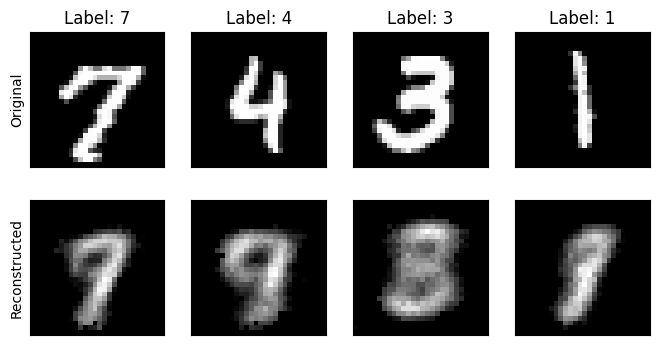

Epoch (2/100): Loss: 44.1609


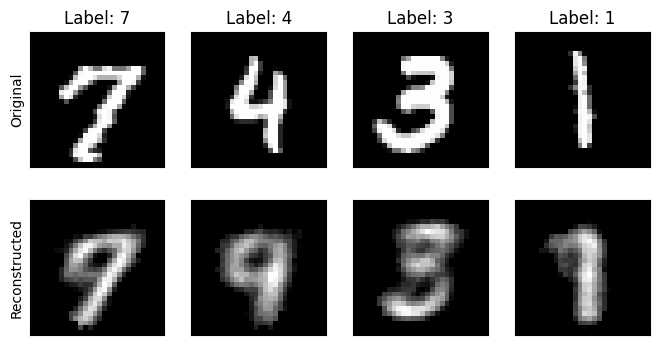

Epoch (3/100): Loss: 41.5365


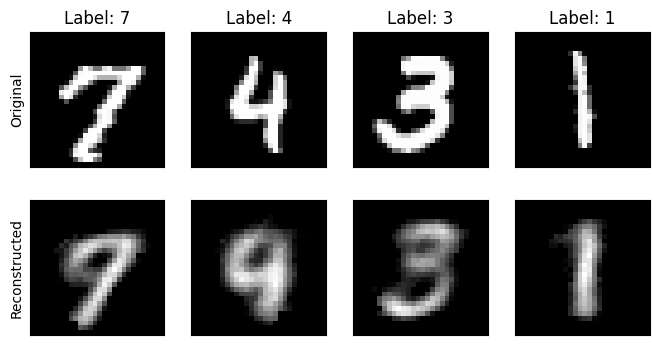

Epoch (4/100): Loss: 40.3063


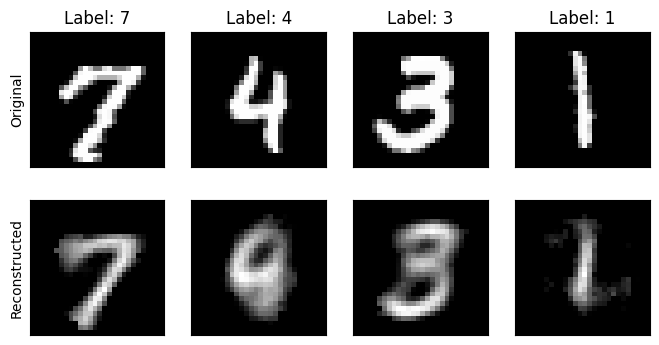

Epoch (5/100): Loss: 38.8593


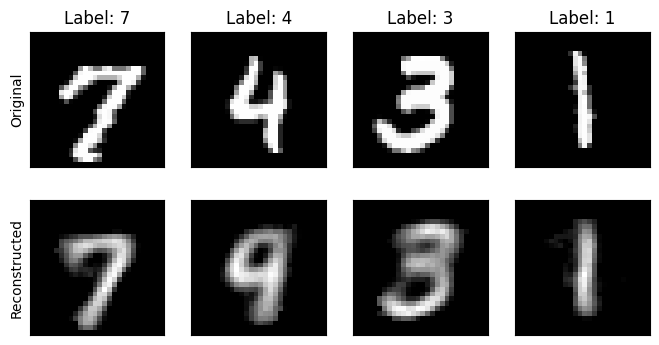

Epoch (6/100): Loss: 38.0462


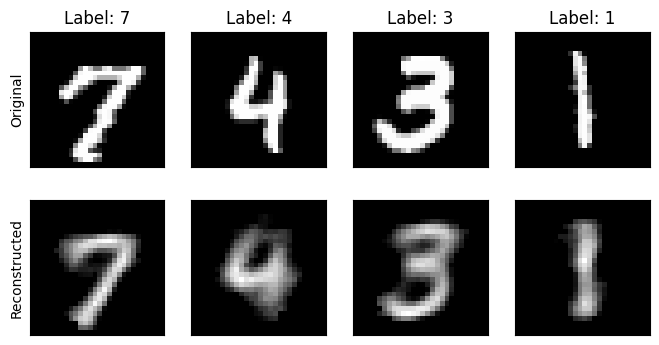

Epoch (7/100): Loss: 37.5135


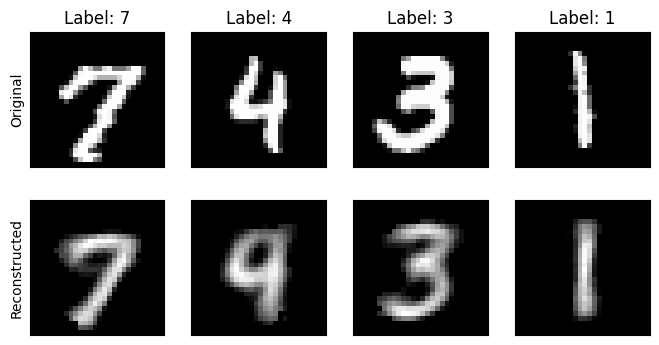

Epoch (8/100): Loss: 37.1185


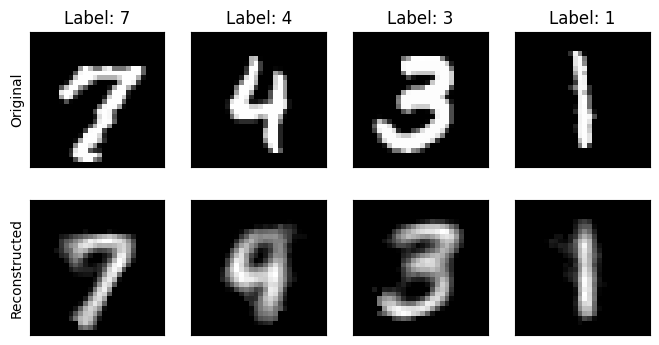

Epoch (9/100): Loss: 36.7956


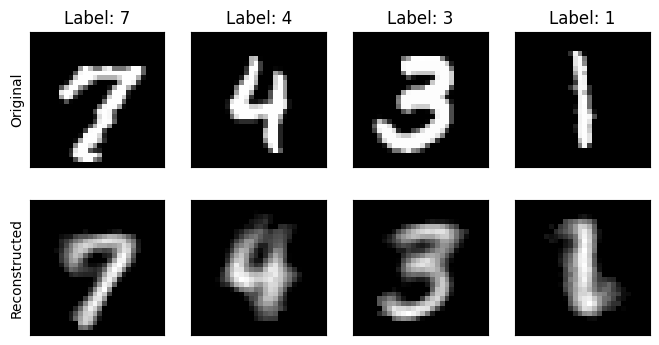

Epoch (10/100): Loss: 36.5325


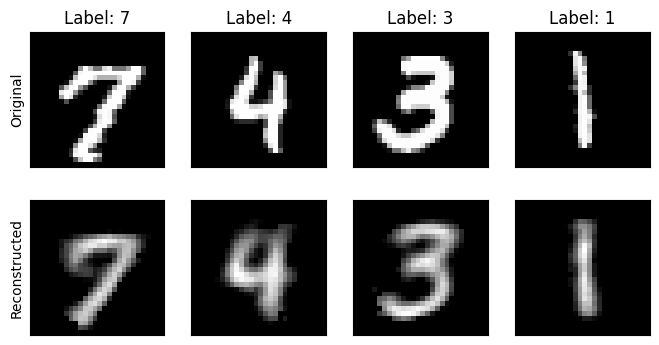

Epoch (11/100): Loss: 36.2892


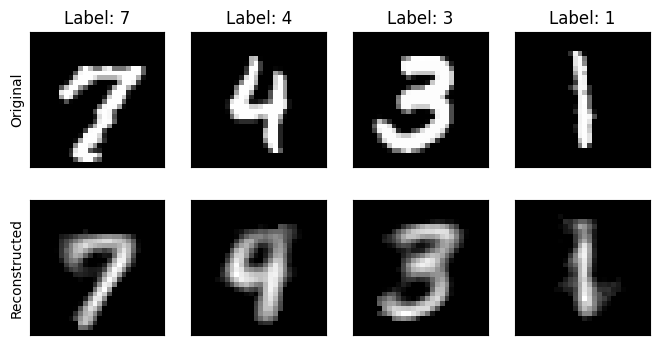

Epoch (12/100): Loss: 36.0590


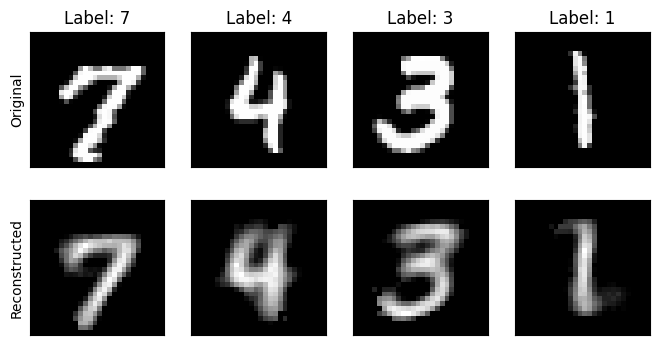

Epoch (13/100): Loss: 35.8366


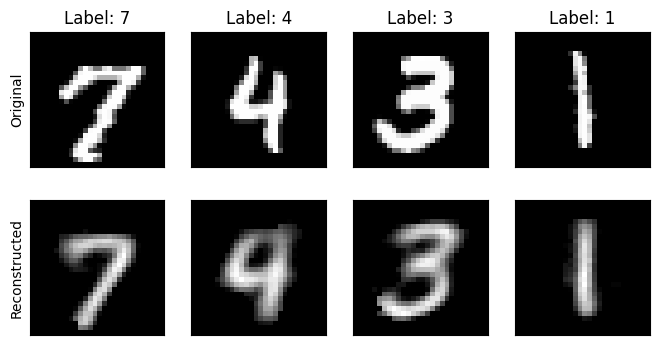

Epoch (14/100): Loss: 35.6065


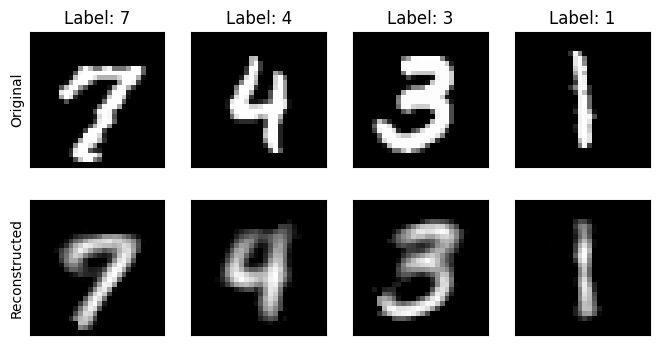

Epoch (15/100): Loss: 35.3611


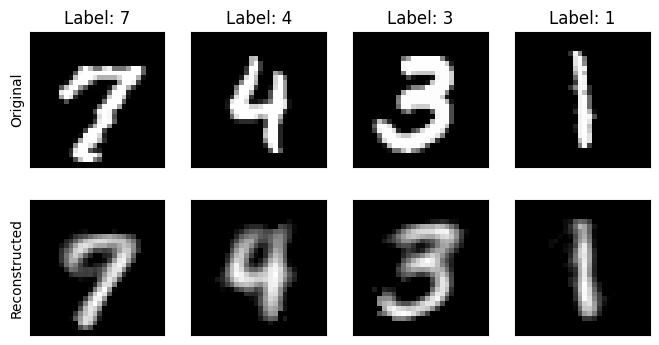

Epoch (16/100): Loss: 35.1286


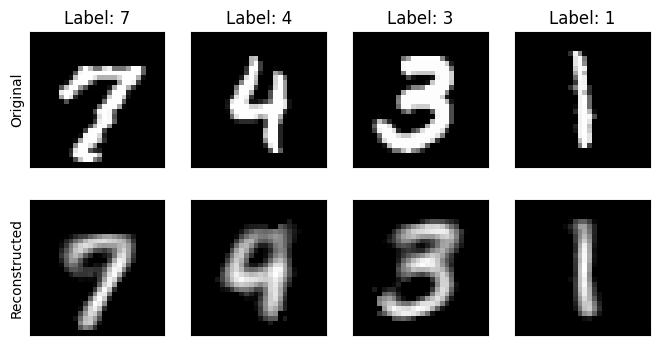

Epoch (17/100): Loss: 34.9114


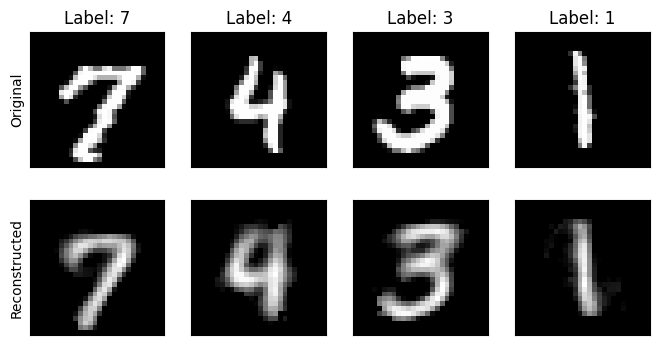

Epoch (18/100): Loss: 34.7313


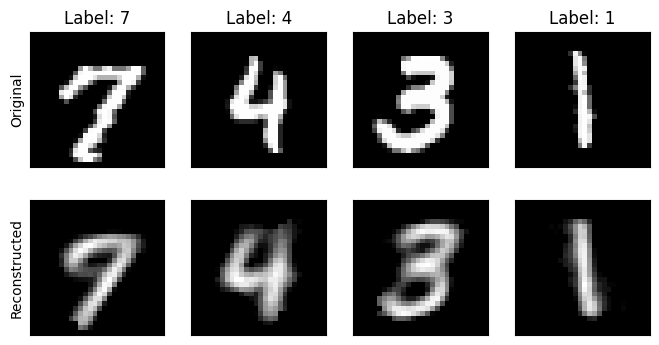

Epoch (19/100): Loss: 34.5517


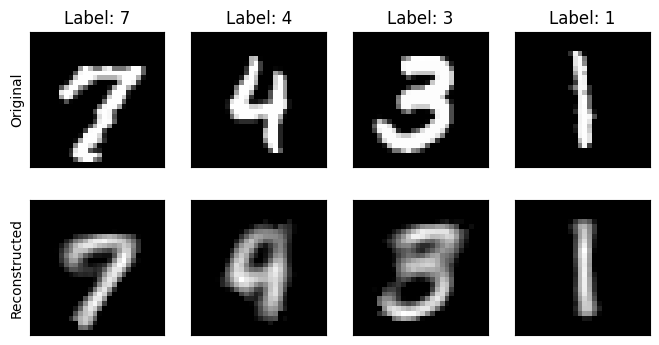

Epoch (20/100): Loss: 34.4075


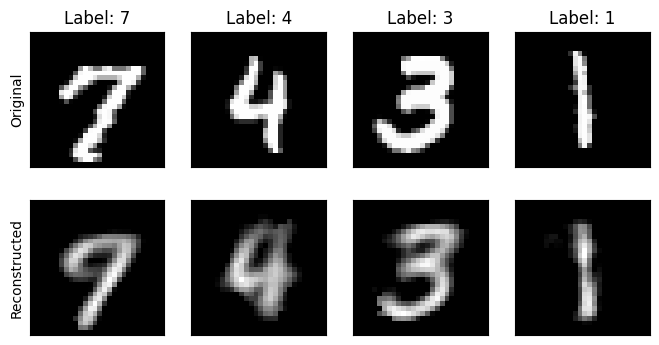

Epoch (21/100): Loss: 34.2570


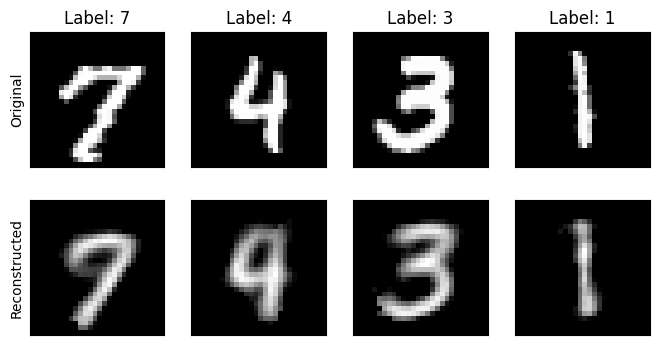

Epoch (22/100): Loss: 34.1335


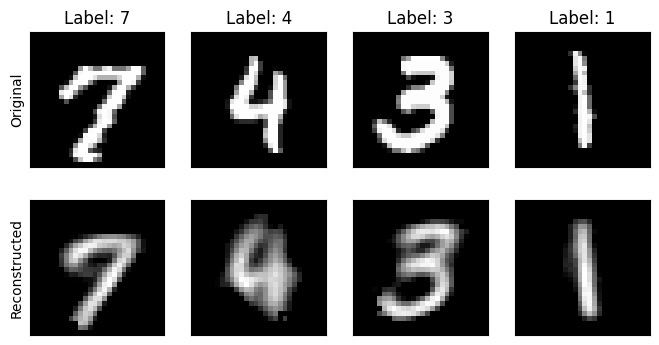

Epoch (23/100): Loss: 34.0211


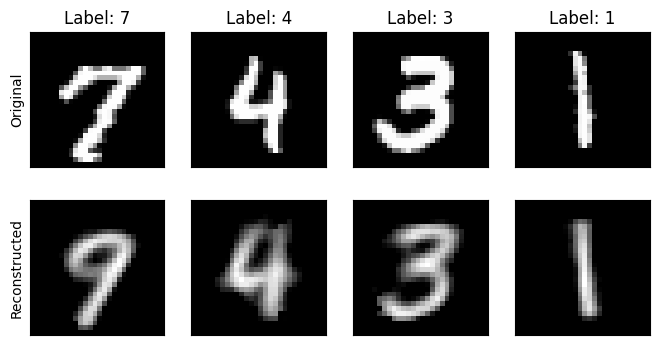

Epoch (24/100): Loss: 33.9153


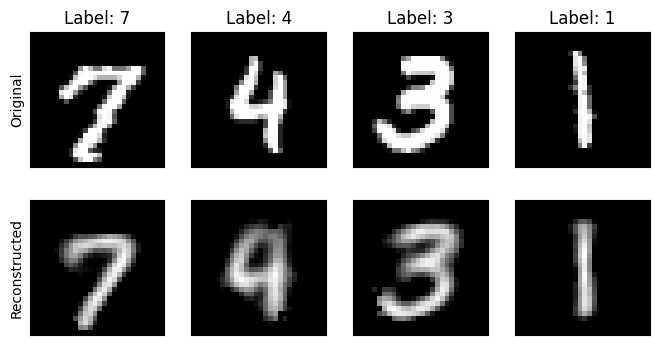

Epoch (25/100): Loss: 33.8276


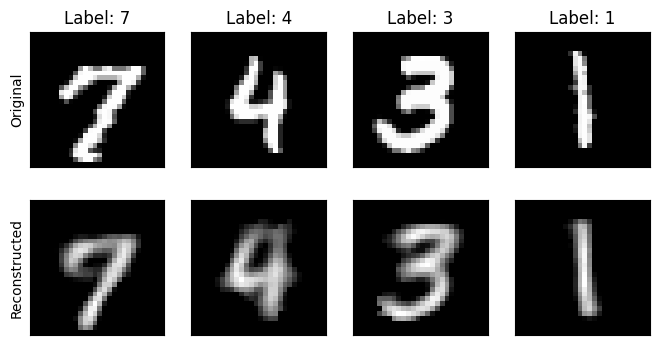

Epoch (26/100): Loss: 33.7498


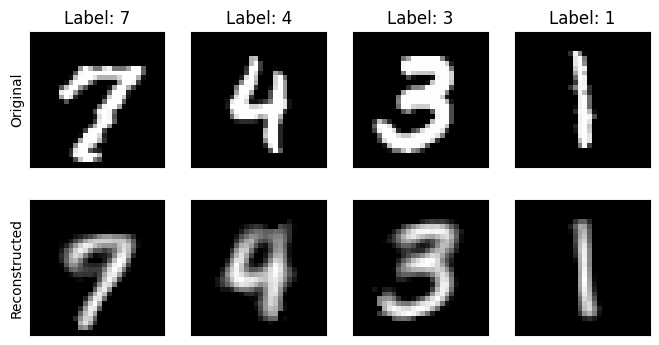

Epoch (27/100): Loss: 33.6663


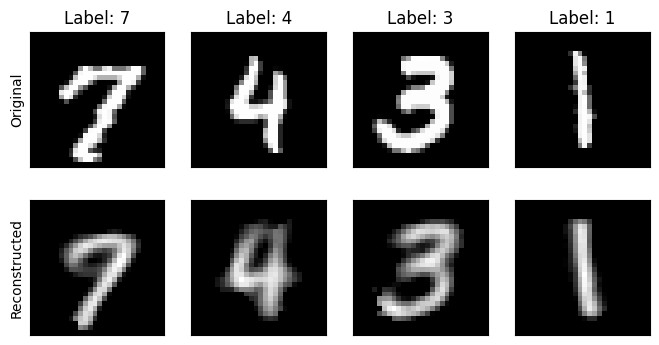

Epoch (28/100): Loss: 33.5747


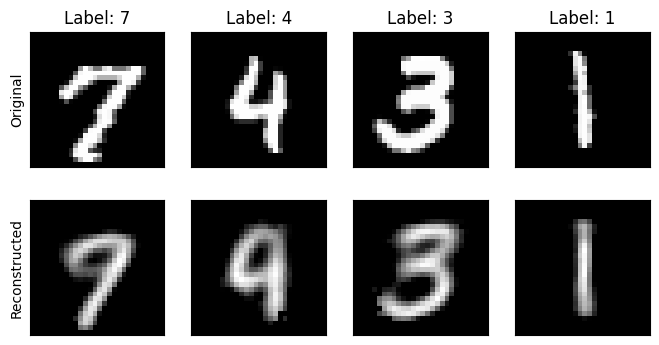

Epoch (29/100): Loss: 33.4939


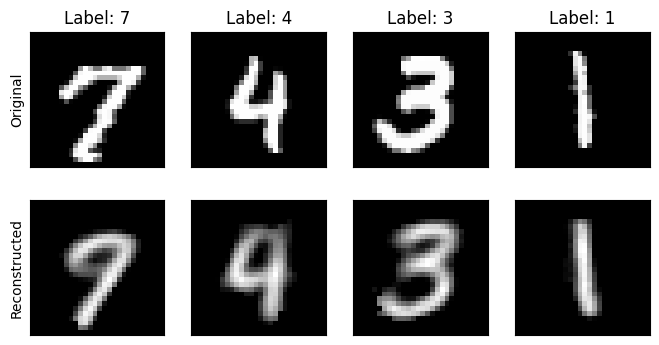

Epoch (30/100): Loss: 33.4393


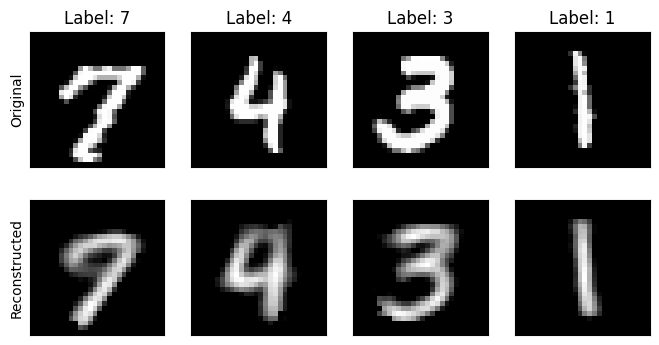

Epoch (31/100): Loss: 33.4055


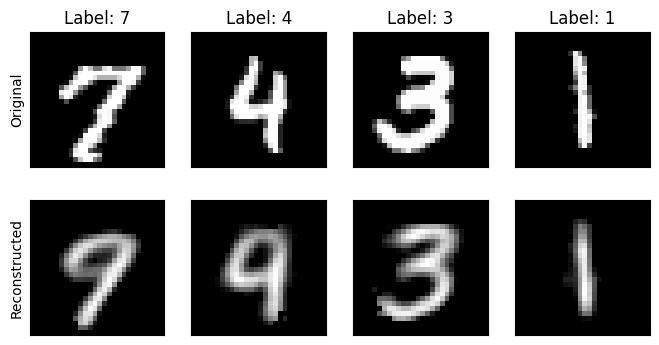

Epoch (32/100): Loss: 33.3429


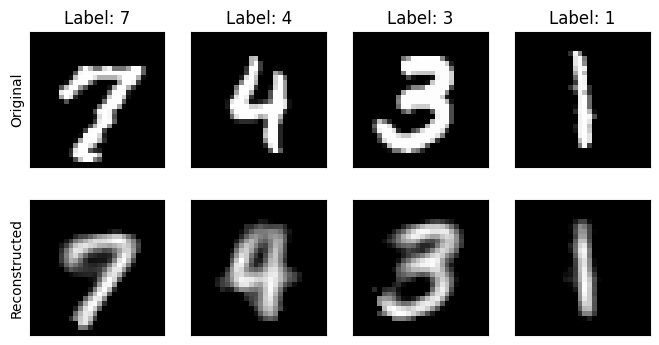

Epoch (33/100): Loss: 33.2730


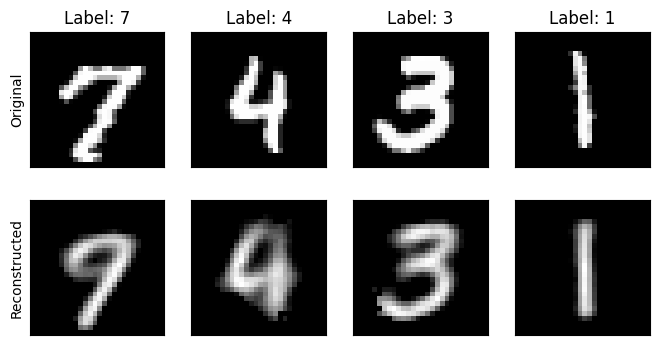

Epoch (34/100): Loss: 33.2014


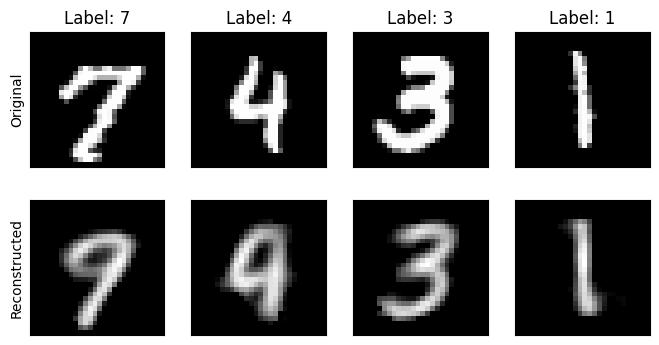

Epoch (35/100): Loss: 33.1324


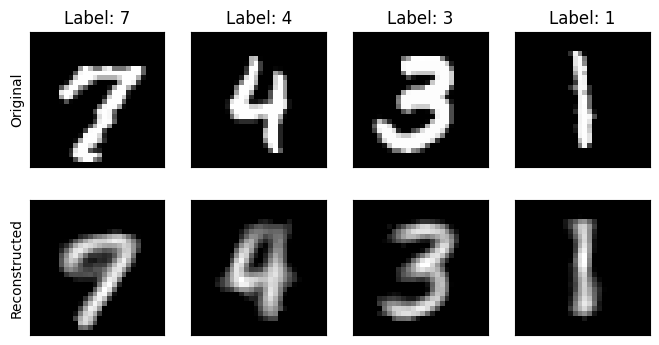

Epoch (36/100): Loss: 33.1069


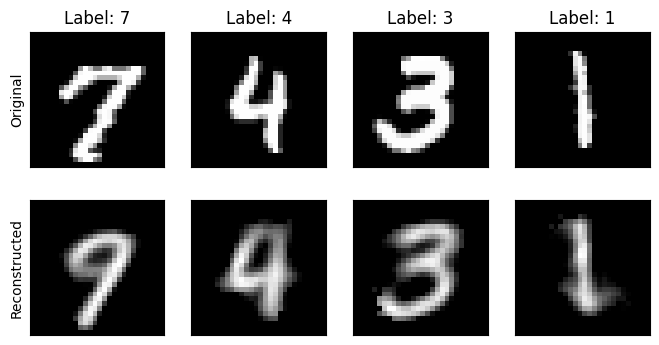

Epoch (37/100): Loss: 33.0568


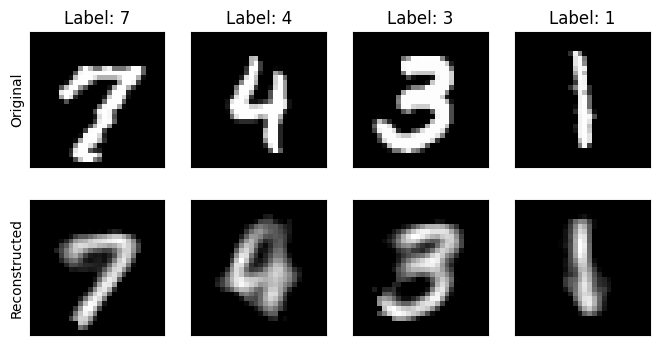

Epoch (38/100): Loss: 33.0149


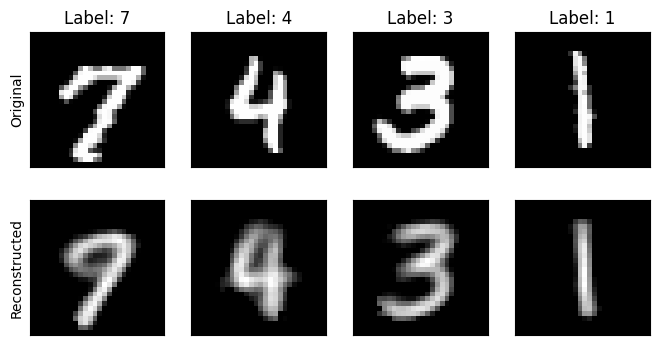

Epoch (39/100): Loss: 32.9860


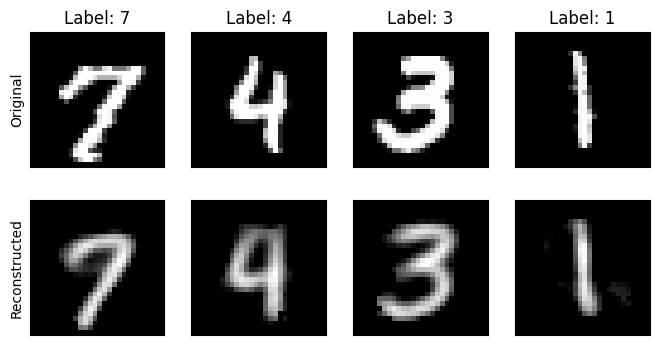

Epoch (40/100): Loss: 32.9328


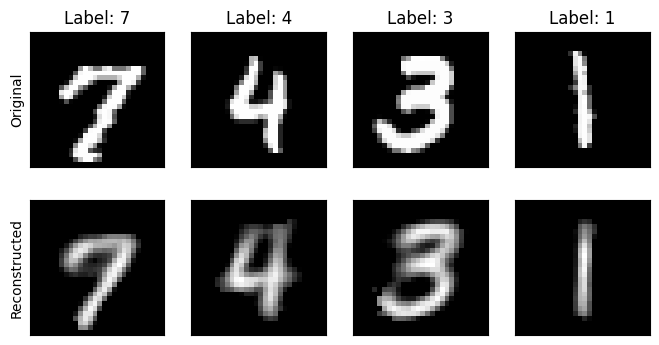

Epoch (41/100): Loss: 32.8771


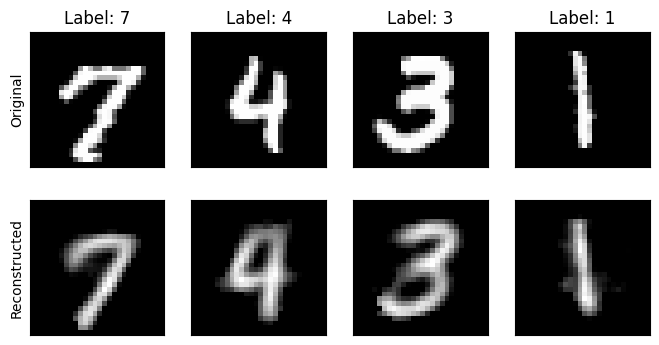

Epoch (42/100): Loss: 32.8610


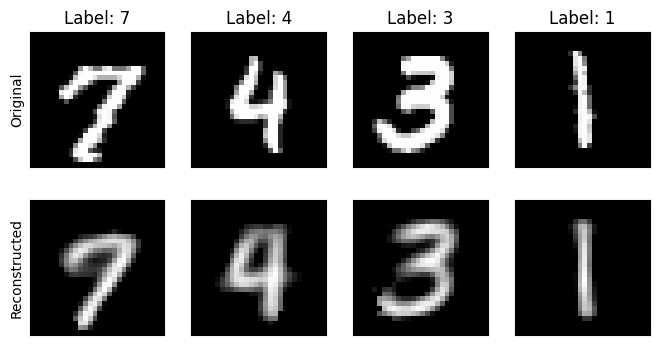

Epoch (43/100): Loss: 32.8168


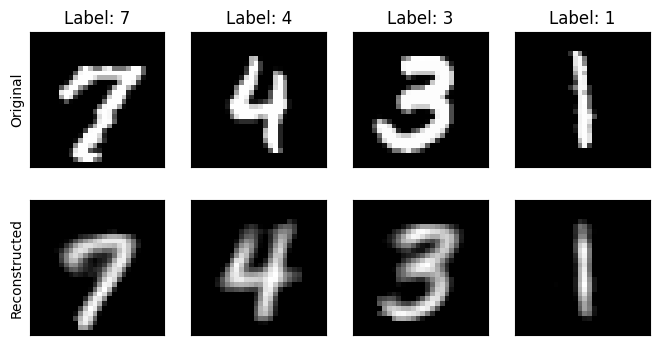

Epoch (44/100): Loss: 32.7840


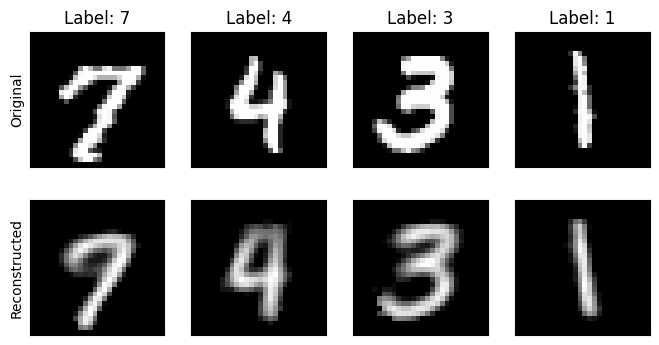

Epoch (45/100): Loss: 32.7394


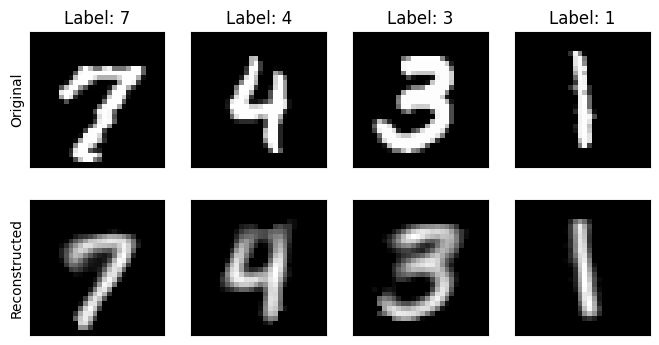

Epoch (46/100): Loss: 32.7146


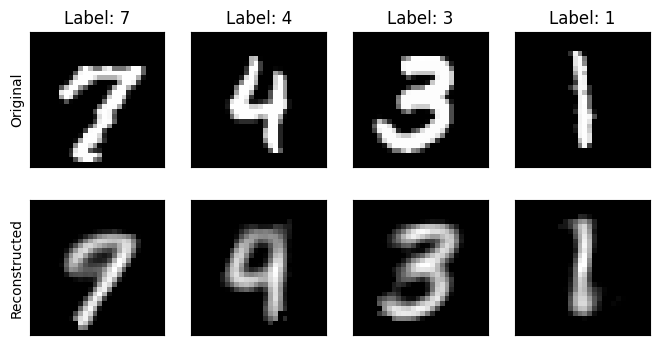

Epoch (47/100): Loss: 32.6909


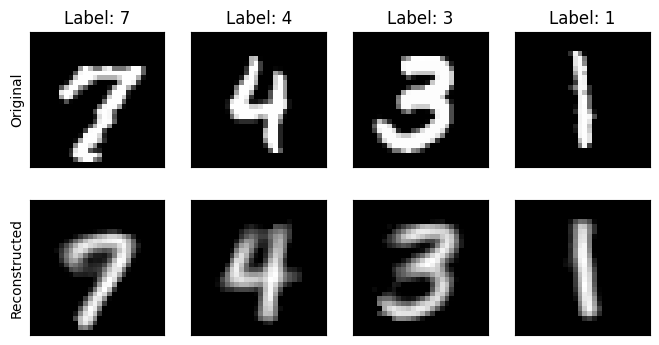

Epoch (48/100): Loss: 32.6491


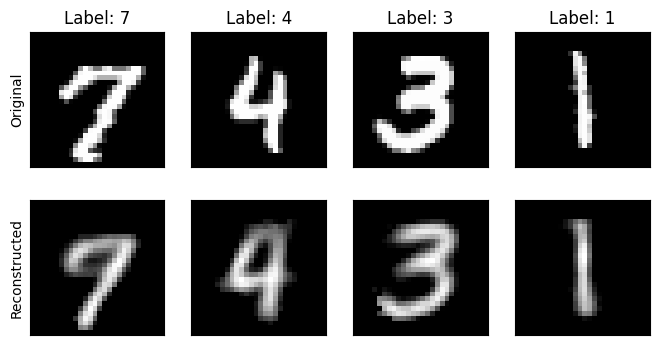

Epoch (49/100): Loss: 32.6166


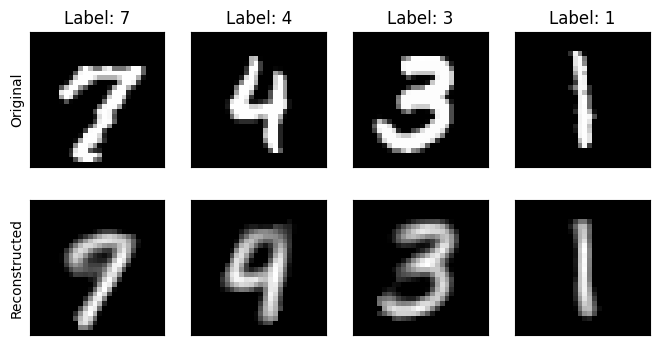

Epoch (50/100): Loss: 32.5868


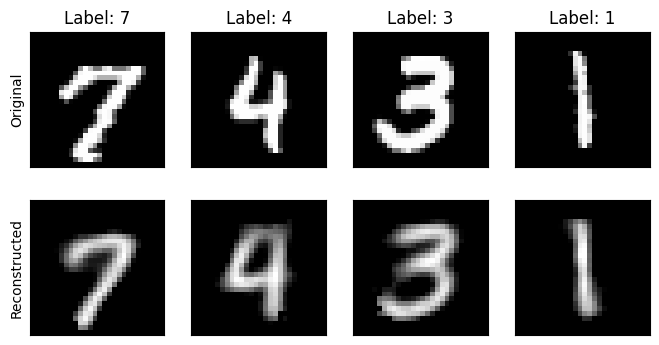

Epoch (51/100): Loss: 32.5562


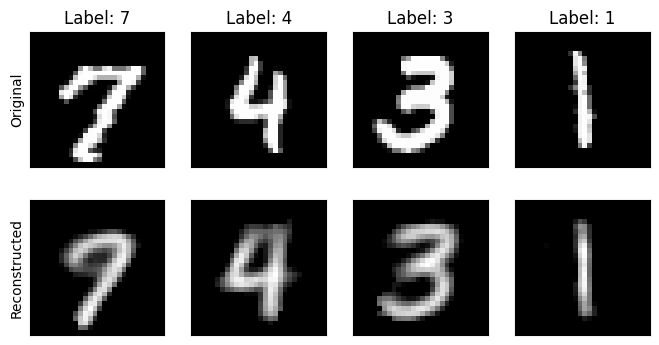

Epoch (52/100): Loss: 32.5481


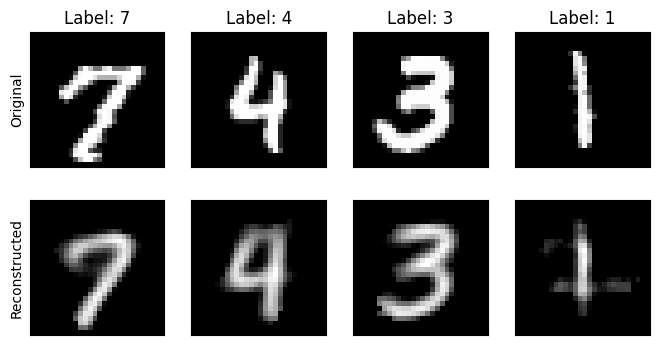

Epoch (53/100): Loss: 32.4972


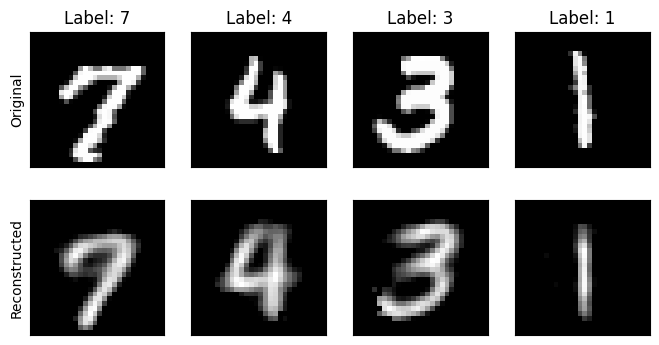

Epoch (54/100): Loss: 32.4716


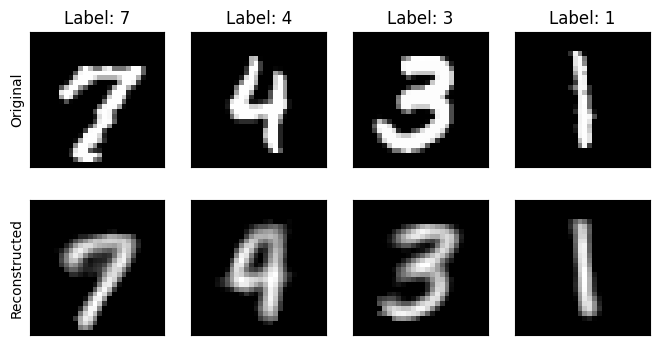

Epoch (55/100): Loss: 32.4633


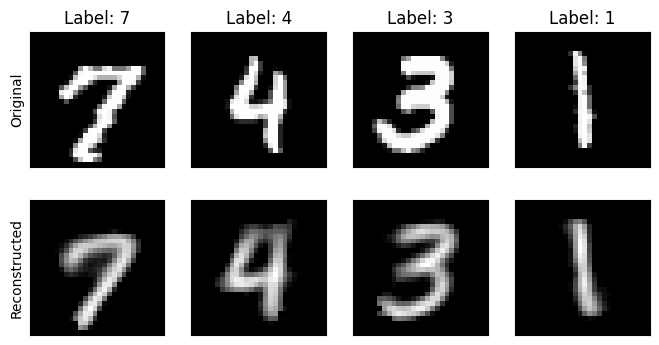

Epoch (56/100): Loss: 32.4583


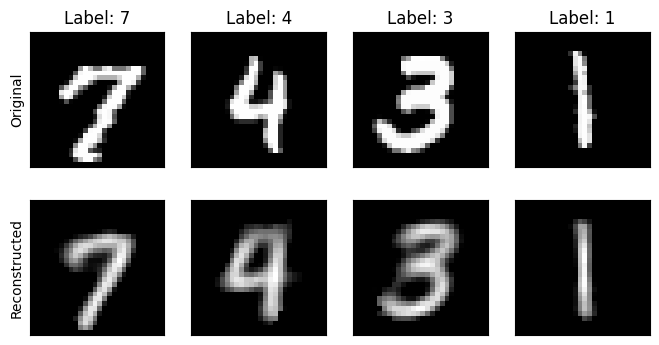

Epoch (57/100): Loss: 32.4068


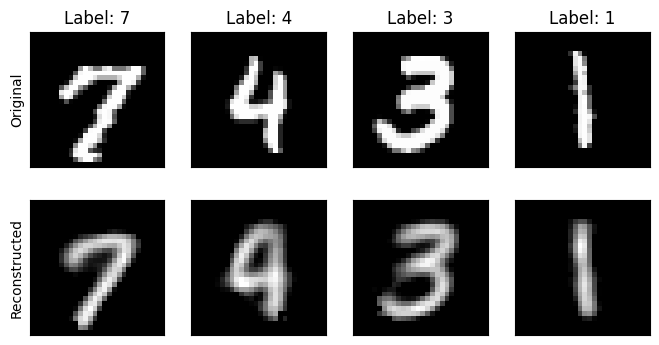

Epoch (58/100): Loss: 32.3885


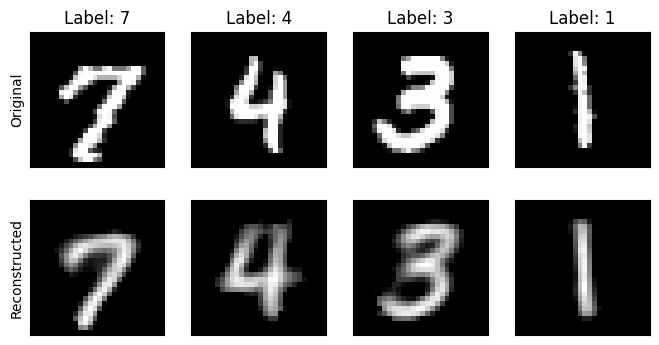

Epoch (59/100): Loss: 32.3491


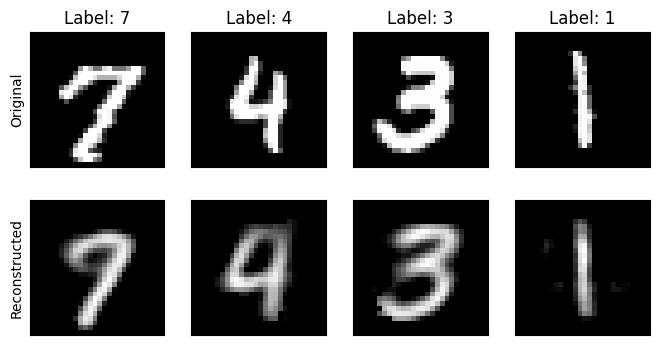

Epoch (60/100): Loss: 32.3417


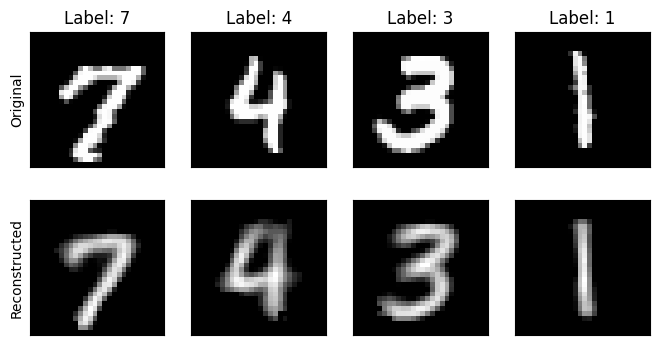

Epoch (61/100): Loss: 32.3220


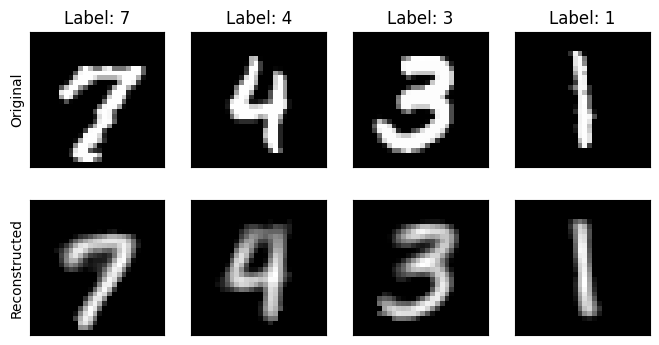

Epoch (62/100): Loss: 32.3184


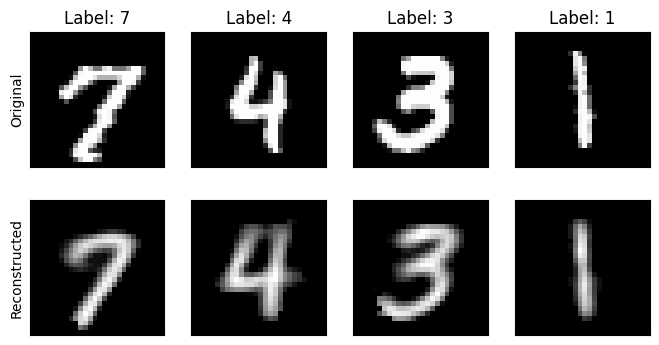

Epoch (63/100): Loss: 32.2829


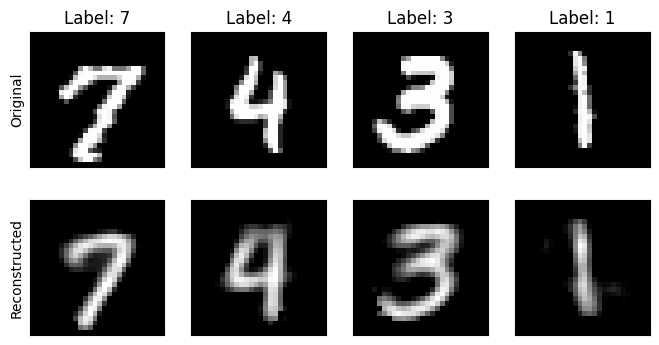

Epoch (64/100): Loss: 32.2702


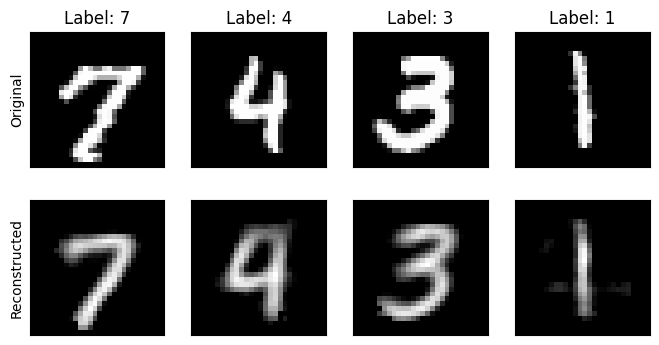

Epoch (65/100): Loss: 32.2371


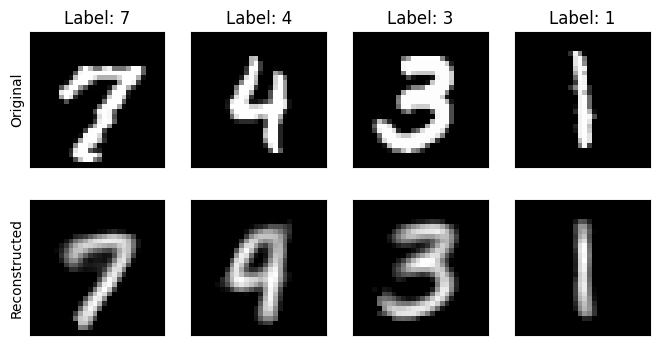

Epoch (66/100): Loss: 32.2012


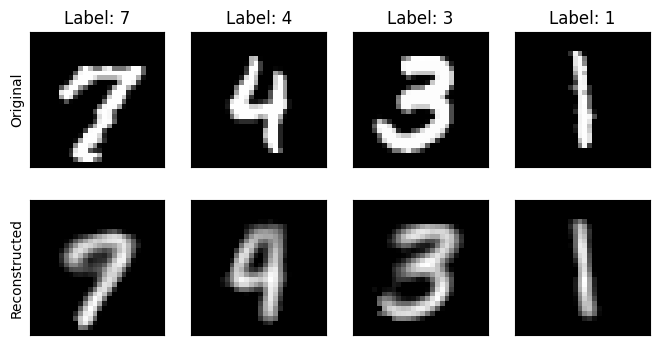

Epoch (67/100): Loss: 32.2024


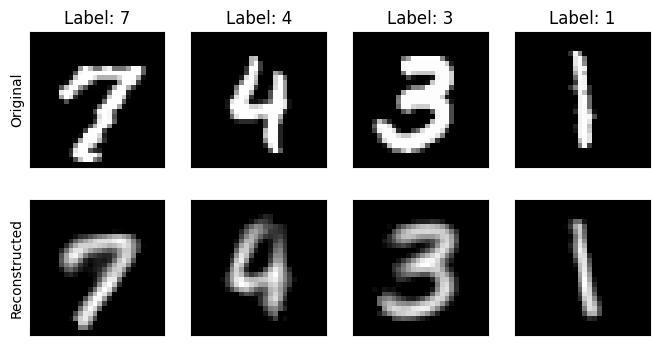

Epoch (68/100): Loss: 32.1684


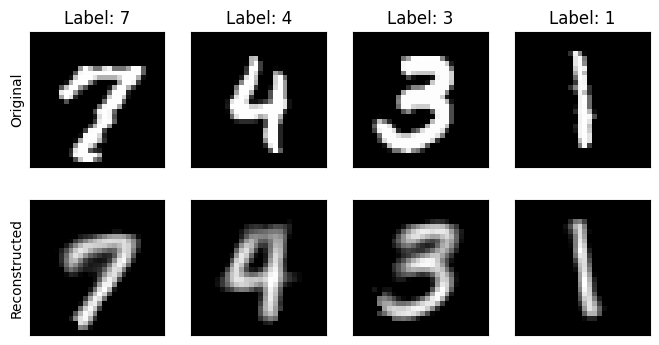

Epoch (69/100): Loss: 32.1617


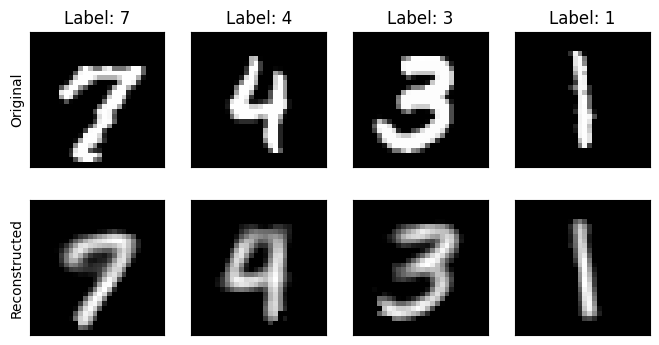

Epoch (70/100): Loss: 32.1210


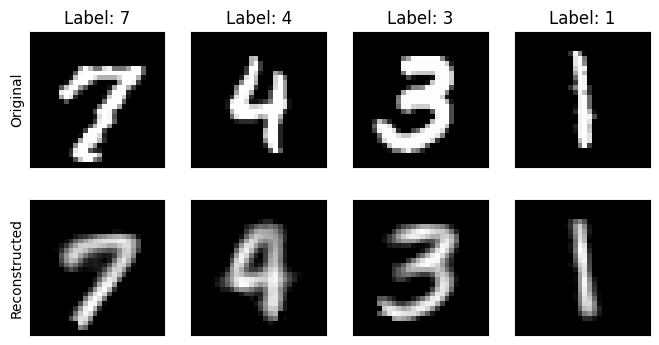

Epoch (71/100): Loss: 32.1284


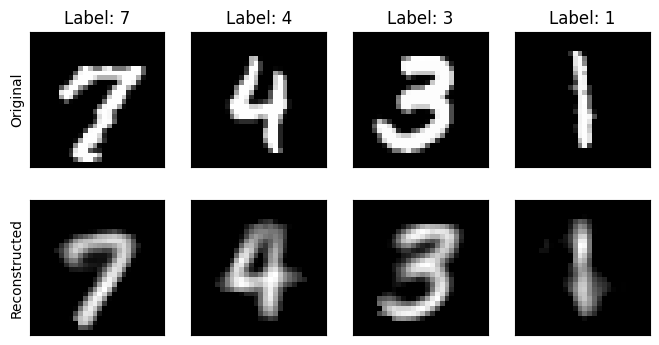

Epoch (72/100): Loss: 32.1019


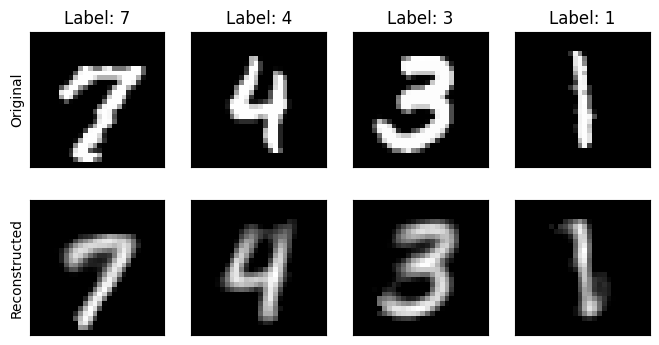

Epoch (73/100): Loss: 32.0663


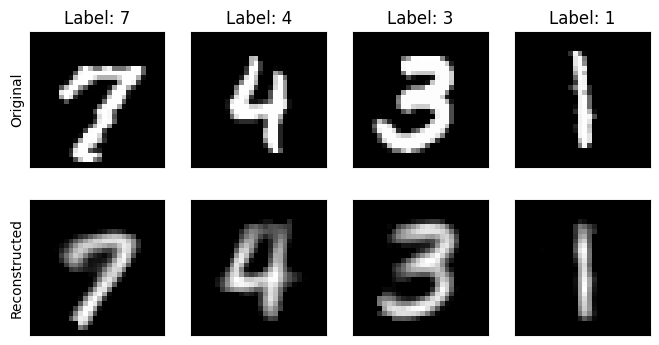

Epoch (74/100): Loss: 32.0832


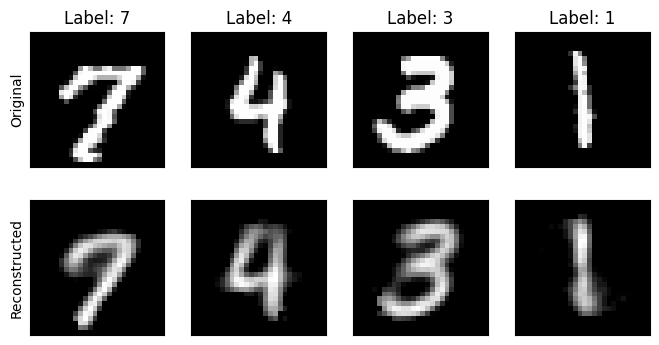

Epoch (75/100): Loss: 32.0648


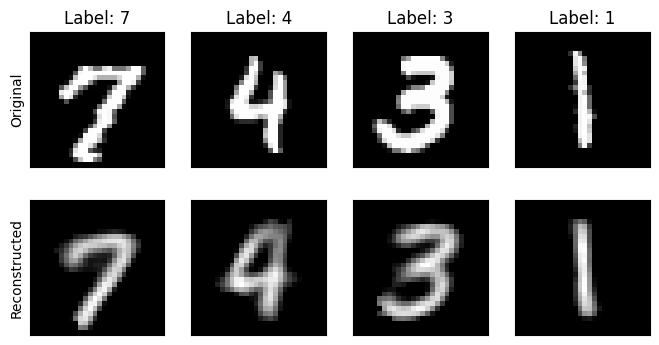

Epoch (76/100): Loss: 32.0319


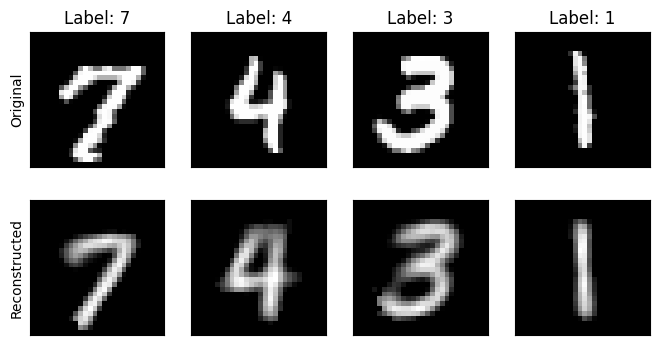

Epoch (77/100): Loss: 32.0188


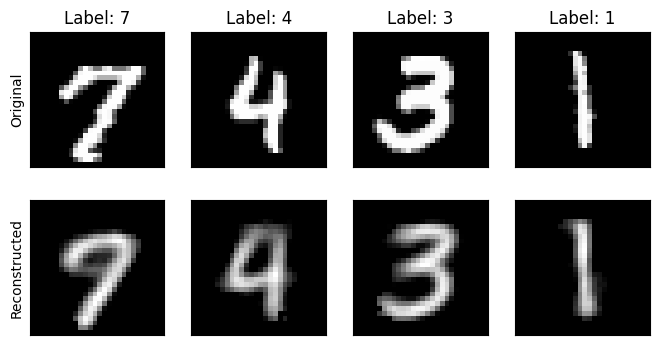

Epoch (78/100): Loss: 32.0193


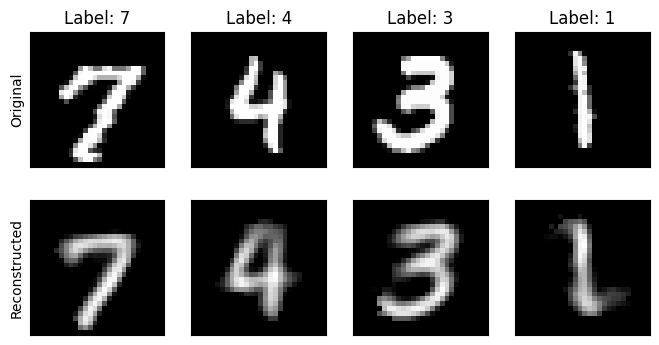

Epoch (79/100): Loss: 32.0016


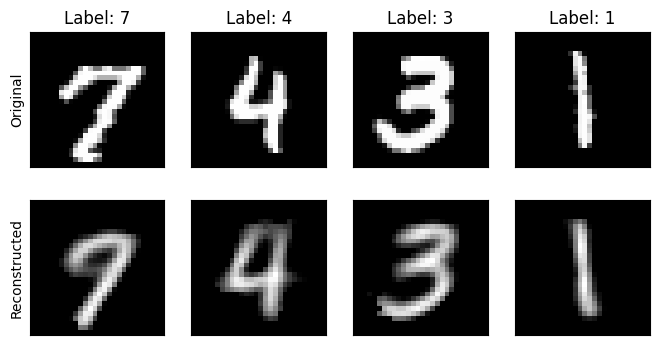

Epoch (80/100): Loss: 31.9867


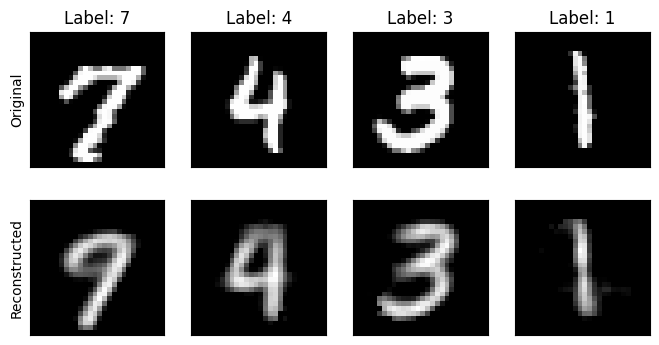

Epoch (81/100): Loss: 31.9553


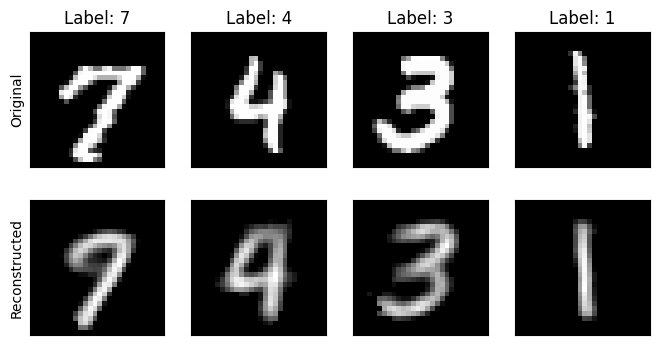

Epoch (82/100): Loss: 31.9227


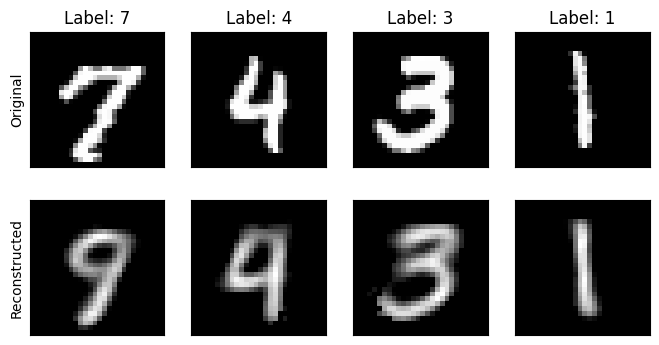

Epoch (83/100): Loss: 31.9274


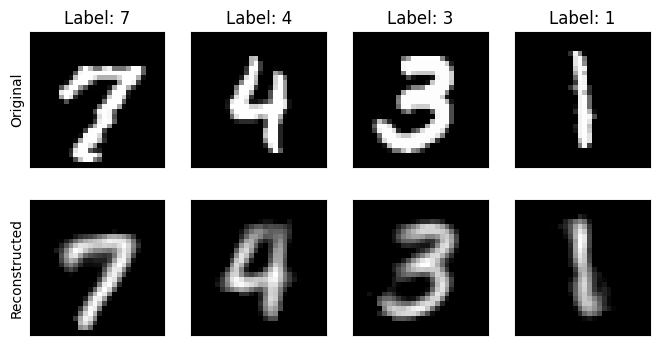

Epoch (84/100): Loss: 31.9095


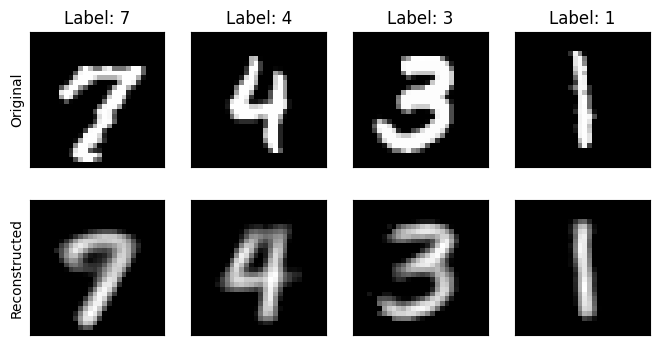

Epoch (85/100): Loss: 31.8886


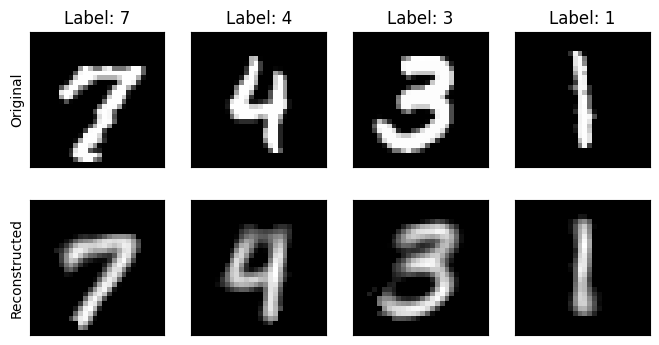

Epoch (86/100): Loss: 31.8827


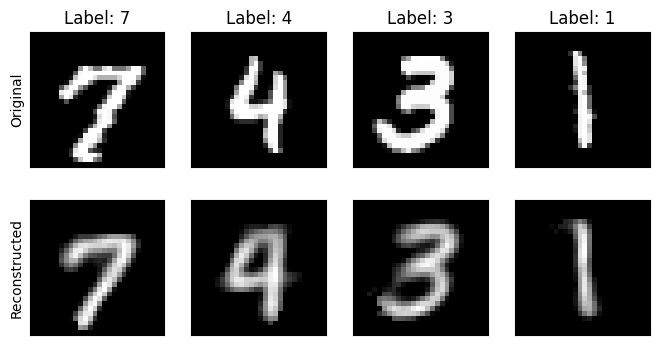

Epoch (87/100): Loss: 31.8813


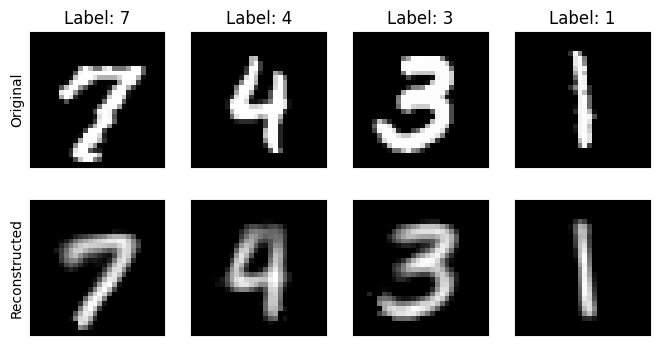

Epoch (88/100): Loss: 31.8538


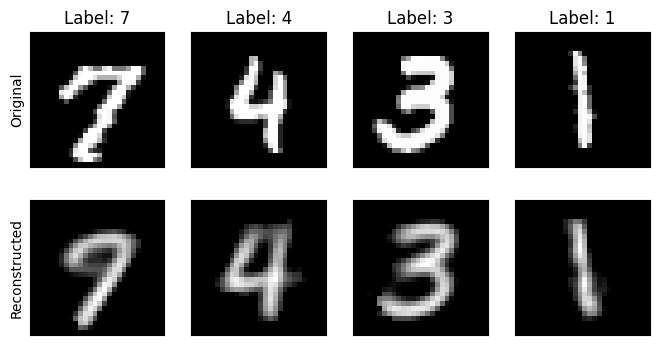

Epoch (89/100): Loss: 31.8330


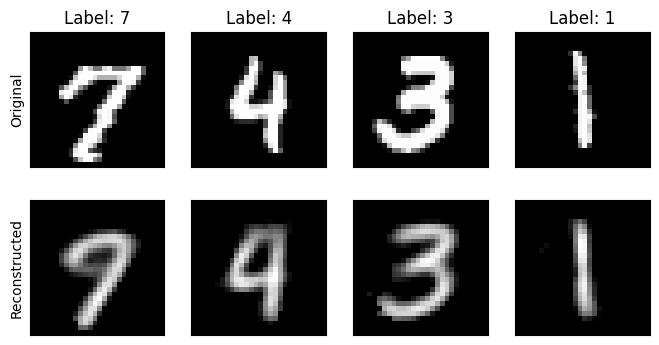

Epoch (90/100): Loss: 31.8206


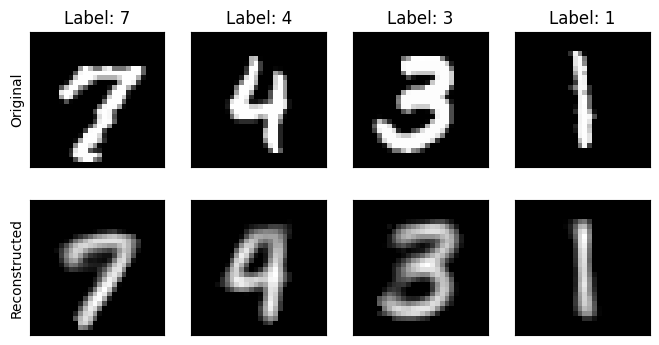

Epoch (91/100): Loss: 31.8255


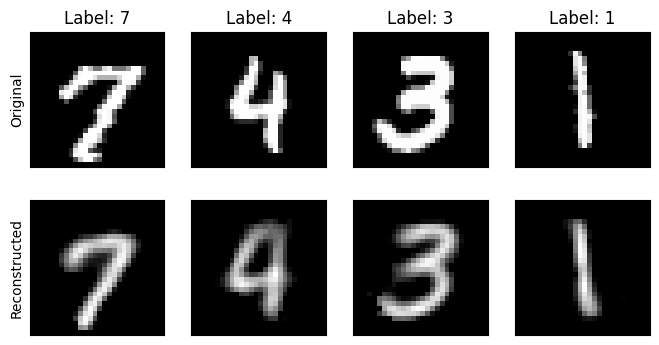

Epoch (92/100): Loss: 31.8111


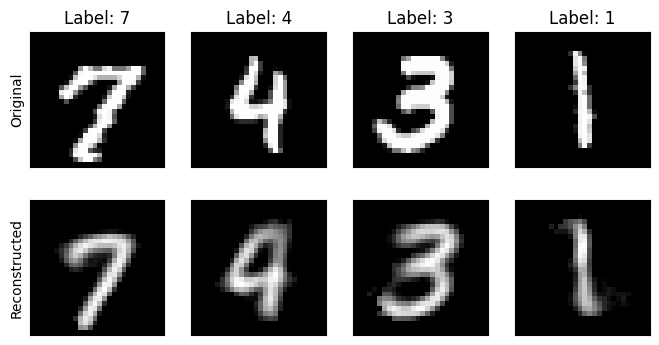

Epoch (93/100): Loss: 31.7910


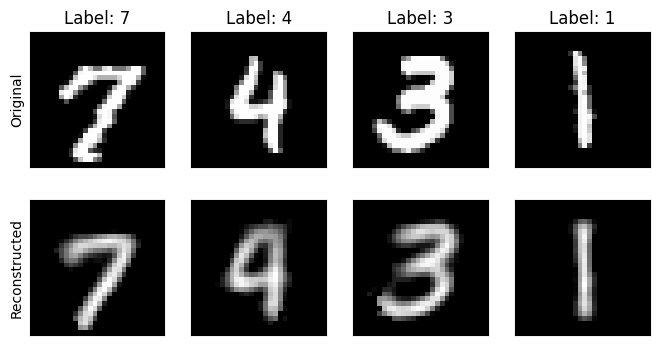

Epoch (94/100): Loss: 31.7770


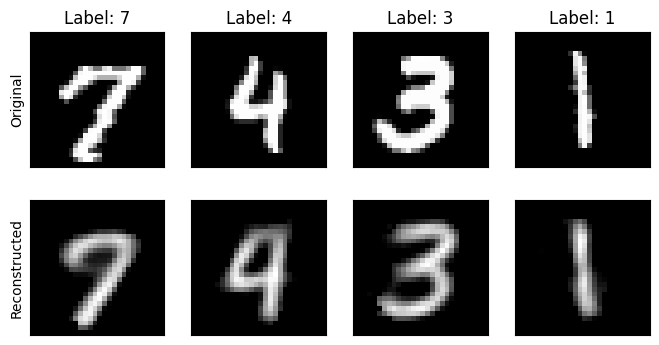

Epoch (95/100): Loss: 31.7820


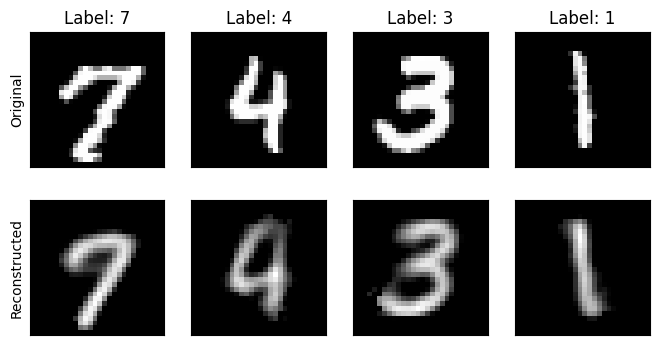

Epoch (96/100): Loss: 31.7556


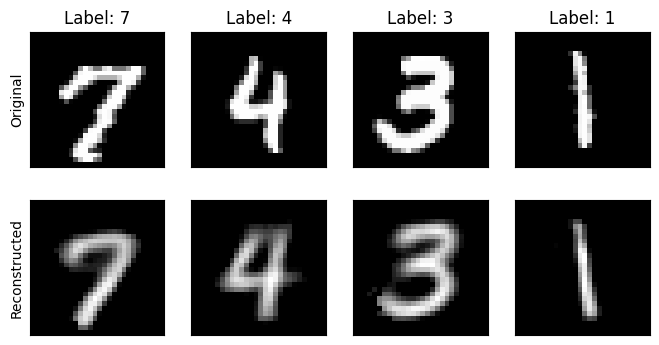

Epoch (97/100): Loss: 31.7454


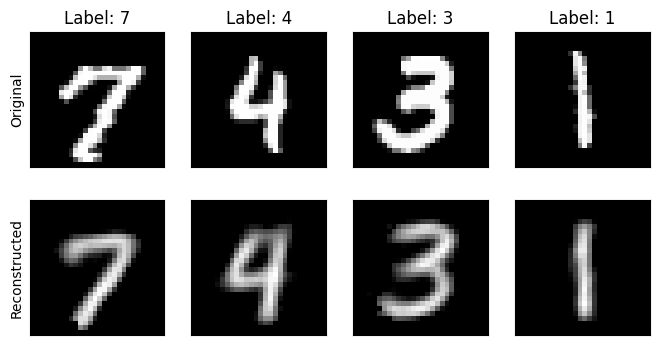

Epoch (98/100): Loss: 31.7340


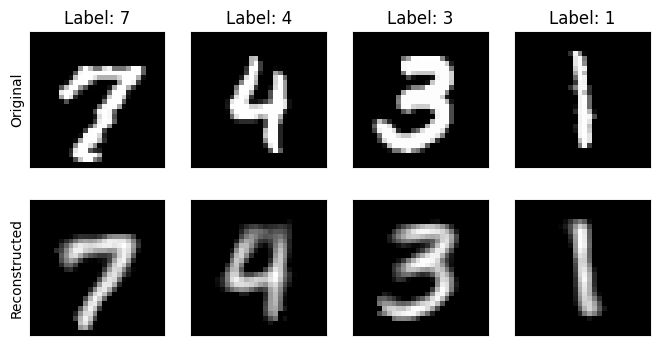

Epoch (99/100): Loss: 31.7164


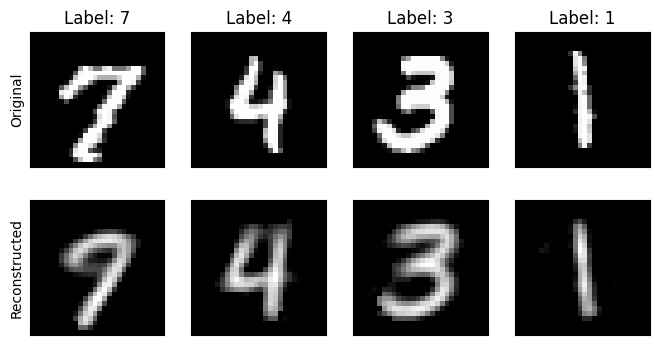

Epoch (100/100): Loss: 31.7134


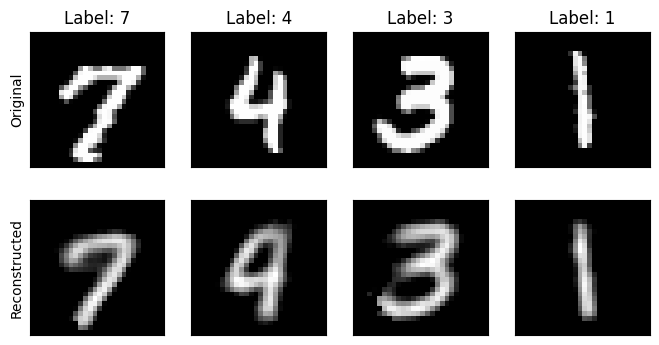

In [20]:
input_dim=784
hidden_dim=256
latent_dim=8

model = VAE(latent_dim=latent_dim, hidden_dim=hidden_dim, input_dim=input_dim).to(DEVICE)

if DEVICE == CUDA:
    model = train_vae(train_loader, model)
    save(model, "vae")
else:
    model.load_state_dict(load('vae'))

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        self.img_shape = img_shape

        self.model = nn.Sequential(
            # TODO
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################

        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        self.model = nn.Sequential(
            # TODO
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        return x

In [ ]:
def train_gan(dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = # TODO
    discriminator = # TODO
    adversarial_loss = # TODO
    optimizer_G = # TODO
    optimizer_D = # TODO

    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################

                # TODO
                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        # Plot generated images after each epoch

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [ ]:
# TODO
# Comparison of the generated images